Number of recordings: 1
All files exist.
Preprocessing Summary
------------------------------------------------------------
hvsrpy_version                           : 2.0.0
orient_to_degrees_from_north             : 0.0
filter_corner_frequencies_in_hz          : (0.5, 20)
window_length_in_seconds                 : 30
detrend                                  : linear
preprocessing_method                     : hvsr
Processing Summary
------------------------------------------------------------
hvsrpy_version                           : 2.0.0
window_type_and_width                    : ('tukey', 0.1)
smoothing                                :
     operator                            : konno_and_ohmachi
     bandwidth                           : 40
     center_frequencies_in_hz            : [0.5, 0.509354980484 ... 3267344611169, 20.0]
fft_settings                             : None
handle_dissimilar_time_steps_by          : frequency_domain_resampling
processing_method                     

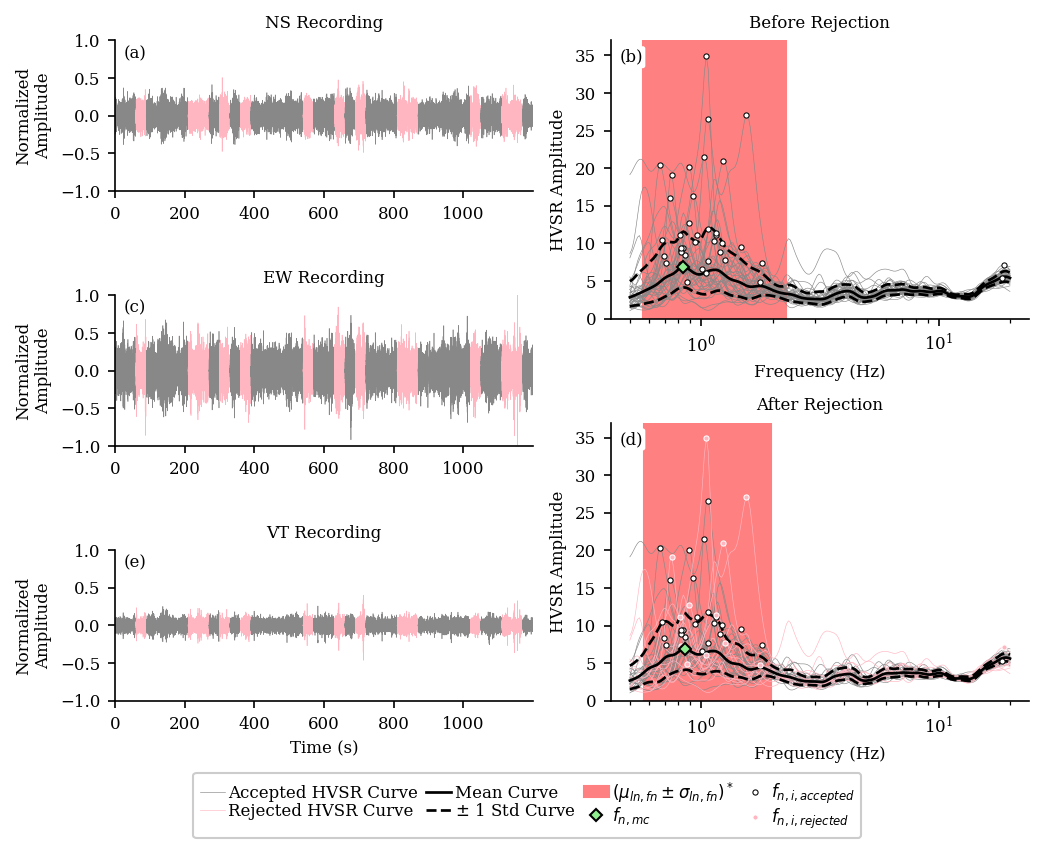


그래프에 표시된 고유 주파수:
  - 주파수 = 0.856 Hz, 진폭 = 6.932


In [2]:
import time
import pathlib
import glob
import os

import numpy as np
import matplotlib.pyplot as plt

import hvsrpy
from hvsrpy import sesame

plt.style.use(hvsrpy.HVSRPY_MPL_STYLE)

def find_enz_files(folder_path):
    """주어진 폴더 경로에서 .E.sac, .N.sac, .Z.sac 파일을 찾아 리스트로 반환합니다."""
    e_file = glob.glob(os.path.join(folder_path, "*.E.sac"))
    n_file = glob.glob(os.path.join(folder_path, "*.N.sac"))
    z_file = glob.glob(os.path.join(folder_path, "*.Z.sac"))

    if e_file and n_file and z_file:
        return sorted([e_file[0], n_file[0], z_file[0]])  # 확장자 순으로 정렬
    else:
        return None

# Input folder path
input_folder = 'C:\\SOLODATA\\try'

fnames = []
enz_files = find_enz_files(input_folder)
if enz_files:
    fnames.append(enz_files)
else:
    raise FileNotFoundError(f"폴더 '{input_folder}'에서 E, N, Z sac 파일을 찾을 수 없습니다.")

print(f"Number of recordings: {len(fnames)}")
for fname_set in fnames:
    for file in fname_set:
        if not pathlib.Path(file).exists():
            raise FileNotFoundError(f"file {file} not found; check spelling.")
print("All files exist.")


preprocessing_settings = hvsrpy.settings.HvsrPreProcessingSettings()
preprocessing_settings.detrend = "linear"
preprocessing_settings.window_length_in_seconds = 30
preprocessing_settings.orient_to_degrees_from_north = 0.0
preprocessing_settings.filter_corner_frequencies_in_hz = (0.5, 20)  # 밴드패스 필터
preprocessing_settings.ignore_dissimilar_time_step_warning = False

print("Preprocessing Summary")
print("-"*60)
preprocessing_settings.psummary()

processing_settings = hvsrpy.settings.HvsrTraditionalProcessingSettings()
processing_settings.window_type_and_width = ("tukey", 0.1)
processing_settings.smoothing=dict(operator="konno_and_ohmachi",
                                   bandwidth=40,
                                   center_frequencies_in_hz=np.geomspace(0.5, 20, 200))
processing_settings.method_to_combine_horizontals = "total_horizontal_energy"
processing_settings.handle_dissimilar_time_steps_by = "frequency_domain_resampling"

print("Processing Summary")
print("-"*60)
processing_settings.psummary()

srecords = hvsrpy.read(fnames) # 입력한 데이터를 hvsrpy 패키지 안에서 처리할 수 있는 형식으로 만듦

# start_time = 4000    # 자르고 싶은 구간의 시작(sec)
# end_time   = 4272    # 구간의 끝(sec)
#for rec in srecords:
#    for comp in ("ns", "ew", "vt"):
#        ts = getattr(rec, comp)   # timeseries.py의 TimeSeries 인스턴스
#        end_time = ts.time()[-1]  # 시계열의 마지막 시간(초)
#        start_time = end_time - 1000  # 시계열의 마지막 시간에서 몇 초 더 뒤로
#        ts.trim(start_time, end_time)

srecords_preprocessed = hvsrpy.preprocess(srecords, preprocessing_settings) #Preprocessing을 거친 데이터 생성
hvsr = hvsrpy.process(srecords_preprocessed, processing_settings) #Processing을 거친 데이터 생성


# Cox et al. (2020) | Frequency-Domain Window Rejection Algorithm
# n = 2
# search_range_in_hz = (None, None)
# _ = hvsrpy.frequency_domain_window_rejection(hvsr, n=n, search_range_in_hz=search_range_in_hz)

# STA-LTA | Short term average - Long term average rejection algorithm
# srecords = hvsrpy.read(fnames) #srecords는 trim 파트에서 이미 선언 되어있기 때문에 상관 X
# srecords_preprocessed = hvsrpy.preprocess(srecords, preprocessing_settings) # 윗 줄과 마찬가지임

passing_records = hvsrpy.sta_lta_window_rejection(
    srecords_preprocessed,
    hvsr=hvsr,
    sta_seconds=1,
    lta_seconds=30,
    min_sta_lta_ratio=0.2,
    max_sta_lta_ratio=2.0
)
#hvsr1=hvsrpy.process(passing_records, processing_settings)


# Max Value | Maximum value window rejection
#srecords = hvsrpy.read(fnames)
#srecords_preprocessed = hvsrpy.preprocess(srecords, preprocessing_settings)
#passing_records = hvsrpy.maximum_value_window_rejection(
#    srecords_preprocessed,
#    hvsr=hvsr,
#    maximum_value_threshold=0.9,  # 필요에 따라 임계치 조정
#    normalized=True                # 상대값 여부
#)
# Manual | Manual value window rejection
# %matplotlib qt5
# hvsr = hvsrpy.manual_window_rejection(hvsr)
mfig, axs = hvsrpy.plot_pre_and_post_rejection(srecords_preprocessed, hvsr)
plt.show()

save_figure = False
save_results = False
fname_prefix = "example_mhvsr_traditional_window_rejection"

if save_figure:
    fname = f"{fname_prefix}_all_panels.png"
    mfig.savefig(fname)
    plt.close()
    print(f"Figure saved successfully to {fname}!")

if save_results:
    fname = f"{fname_prefix}.csv"
    hvsrpy.object_io.write_hvsr_object_to_file(hvsr, fname)
    print(f"Results saved successfully to {fname}!")

# 고유 주파수 값 출력 (그래프에 표시된 마름모 값)
if hvsr and hasattr(hvsr, 'mean_curve'):
    mean_curve = hvsr.mean_curve()
    peak_frequency = hvsr.frequency[np.argmax(mean_curve)]  # 최대값의 주파수
    peak_amplitude = np.max(mean_curve)

    print("\n그래프에 표시된 고유 주파수:")
    print(f"  - 주파수 = {peak_frequency:.3f} Hz, 진폭 = {peak_amplitude:.3f}")
else:
    print("\nHVSR 결과에서 고유 주파수를 찾을 수 없습니다.")